# DATA 604 HW4

Magnus Skonberg | June 21st 2021

These exercises and their solutions were made with reference to *Modeling and Simulation in Python* (version 3) authored by Allen B. Downey. This week's exercises focused on **Prediction & Analysis**, chapters 8 and 9 of the text.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

## Chapter 8

### Functions from Previous Chapter

In [2]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

### Reading data

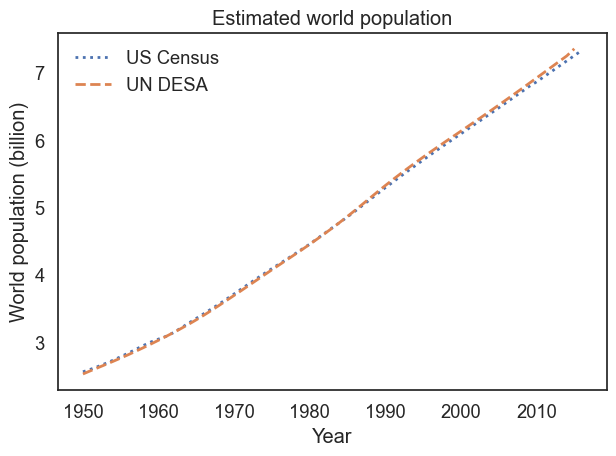

In [3]:
def read_table2(filename = 'data/World_population_estimates.html'):
    tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
    table2 = tables[2]
    table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']
    return table2

table2 = read_table2()
table2.to_csv('data/World_population_estimates2.csv')

table2 = pd.read_csv('data/World_population_estimates2.csv')
table2.index = table2.Year
#table2.head()

un = table2.un / 1e9
census = table2.census / 1e9

plot(census, ':', label='US Census')
plot(un, '--', label='UN DESA')
    
decorate(xlabel='Year', 
         ylabel='World population (billion)',
         title='Estimated world population')


### Running the Quadratic Model

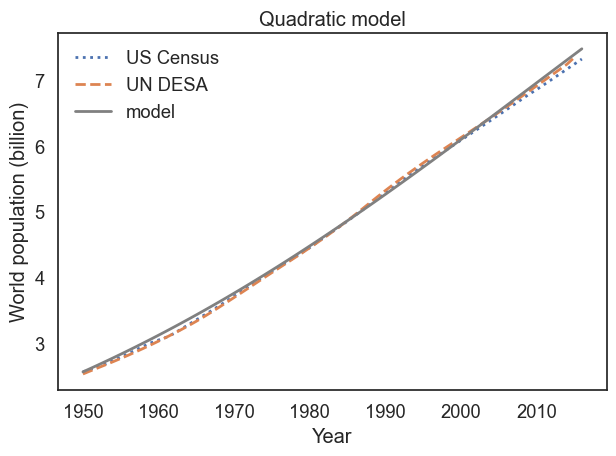

In [4]:
#Update function for quadratic model with alpha, beta
def update_func_quad(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

#Extract start time and population
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = get_first_value(census)

#Initialize system object
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

#Run model and plot results
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'Quadratic model')

### Generating projections

Saving figure to file figs/chap08-fig01.pdf


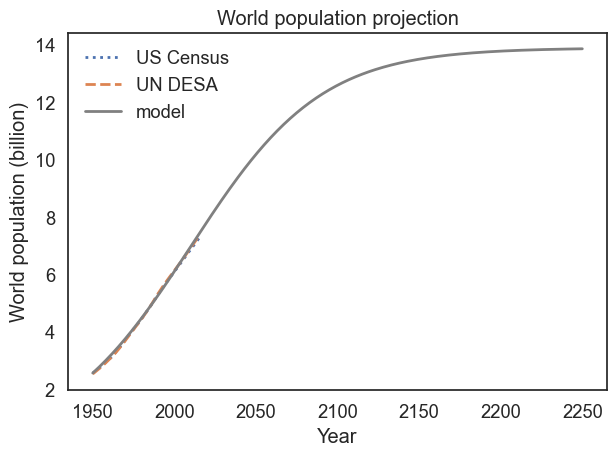

In [5]:
system.t_end = 2250
results = run_simulation(system, update_func_quad)
plot_results(census, un, results, 'World population projection')
savefig('figs/chap08-fig01.pdf')

#Population model converges on equilibrium population: -alpha/beta 
#results[system.t_end]
#-system.alpha / system.beta

### Exercise

What happens if we start with an initial population above the carrying capacity, like 20 billion?  Run the model with initial populations between 1 and 20 billion, and plot the results on the same axes.

Saving figure to file figs/chap08-fig02.pdf


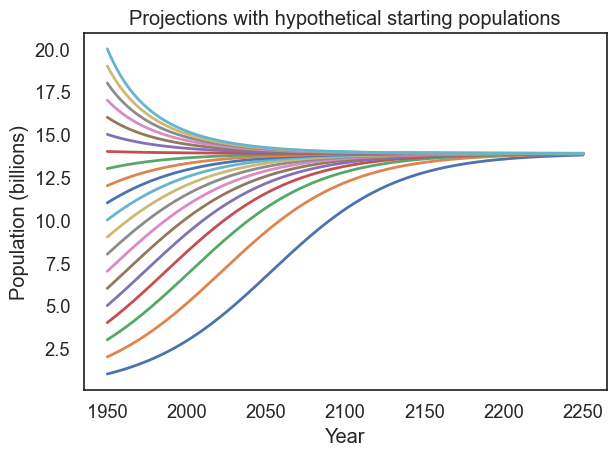

In [6]:
# Initial population from 1 to 20
inl_pop = linspace(1, 20, 20) 

#assign system.p_0 to each iteration thru inl_pop, run simulation, plot result
for system.p_0 in inl_pop:
    results = run_simulation(system, update_func_quad)
    plot(results)
    
decorate(xlabel='Year',
         ylabel='Population (billions)',
         title='Projections with hypothetical starting populations')

savefig('figs/chap08-fig02.pdf')


Regardless of the initial population, even considering a start well above the carrying capacity (ie. 20 billion), our results converge on ~14 billion the equilibrium population (`-alpha/beta`).

### Comparing projections

Saving figure to file figs/chap08-fig03.pdf


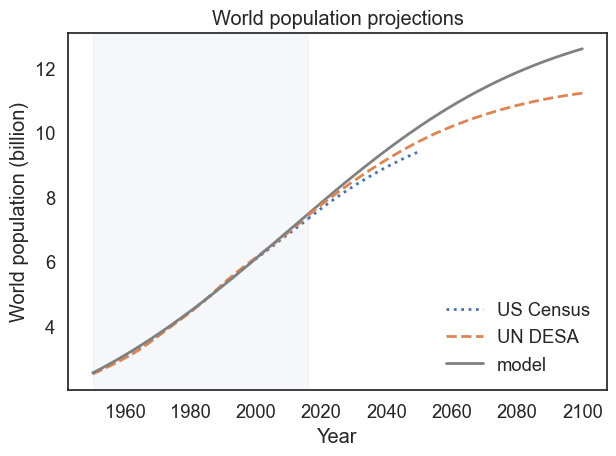

In [7]:
# Compare our projections vs. those of people who know what they're doing

def read_table3(filename = 'data/World_population_estimates.html'):
    tables = pd.read_html(filename, header=0, index_col=0, decimal='M')
    table3 = tables[3]
    table3.columns = ['census', 'prb', 'un']
    return table3

table3 = read_table3()
table3.to_csv('data/World_population_estimates3.csv')

table3 = pd.read_csv('data/World_population_estimates3.csv')
table3.index = table3.Year
table3.head()

#plot projections without NAs

def plot_projections(table):
    """Plot world population projections.
    
    table: DataFrame with columns 'un' and 'census'
    """
    census_proj = table.census / 1e9
    un_proj = table.un / 1e9
    
    plot(census_proj.dropna(), ':', color='C0', label='US Census')
    plot(un_proj.dropna(), '--', color='C1', label='UN DESA')

system = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha=0.025,
                beta=-0.0018)

results = run_simulation(system, update_func_quad)

plt.axvspan(1950, 2016, color='C0', alpha=0.05)
plot_results(census, un, results, 'World population projections')
plot_projections(table3)
savefig('figs/chap08-fig03.pdf')

People who know what they are doing expect the growth rate to decline more sharply than our model projects.

## Exercises

The net growth rate of world population has been declining for several decades. That observation suggests one more way to generate projections, by extrapolating observed changes in growth rate.

The `modsim` library provides a function, `compute_rel_diff`, that computes relative differences of the elements in a sequence.

Here's how we can use it to compute the relative differences in the `census` and `un` estimates:

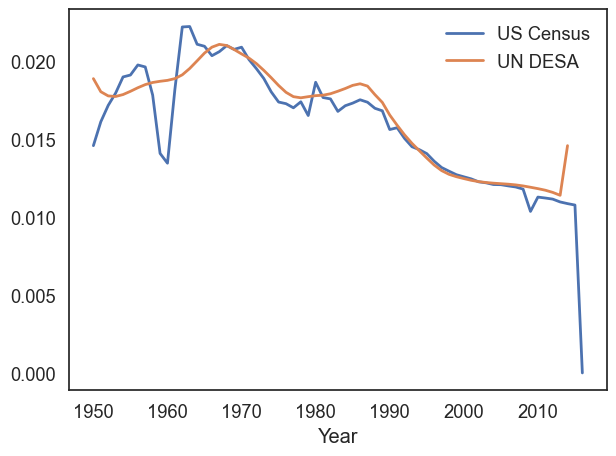

In [8]:
alpha_census = compute_rel_diff(census)
plot(alpha_census, label='US Census')

alpha_un = compute_rel_diff(un)
plot(alpha_un, label='UN DESA')

decorate(xlabel='Year', label='Net growth rate')

Other than a bump around 1990, net growth rate has been declining roughly linearly since 1965.  As an exercise, you can use this data to make a projection of world population until 2100.

1. Define a function, `alpha_func`, that takes `t` as a parameter and returns an estimate of the net growth rate at time `t`, based on a linear function `alpha = intercept + slope * t`.  Choose values of `slope` and `intercept` to fit the observed net growth rates since 1965.

2. Call your function with a range of `ts` from 1960 to 2020 and plot the results.

3. Create a `System` object that includes `alpha_func` as a system variable.

4. Define an update function that uses `alpha_func` to compute the net growth rate at the given time `t`.

5. Test your update function with `t_0 = 1960` and `p_0 = census[t_0]`.

6. Run a simulation from 1960 to 2100 with your update function, and plot the results.

7. Compare your projections with those from the US Census and UN.

In [9]:
#1. I used the plot above, based on census data, to guide intercept and slope values

def alpha_func(t):
    
    """Update alpha based on net growth rate and time
    
    t: input year
    intercept: net growth rate in 1965
    slope: difference in net growth rate from 2010 to 1965
    alpha: linear function of intercept and slope
    
    """
    
    intercept = alpha_census[1965] #0.021
    slope = ((alpha_census[2010] - alpha_census[1965]) / (2010 - 1965)) * 0.9 #added tweaking factor to improve accuracy
    alpha = intercept + slope * (t - 1965)
    
    return alpha
    

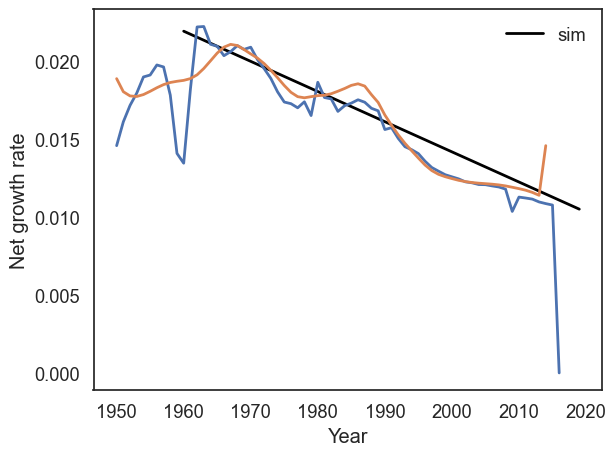

In [10]:
#2.

t_range = linrange(1960, 2020)
alpha_sim = TimeSeries(alpha_func(t_range), t_range)
plot(alpha_sim, color='black', label='sim')
plot(alpha_census)
plot(alpha_un)

decorate(xlabel='Year', ylabel='Net growth rate')


In [11]:
#3.

system = System(t_0=t_0, 
                t_end=2100,
                p_0=p_0,
                alpha_func = alpha_func
               )

,values
t_0,1950
t_end,2100
p_0,2.557629
alpha_func,<function alpha_func at 0x000001E0709DEDC0>


In [12]:
#4.

#Update function for alpha_func model
def update_alpha_func(pop, t, system):
    """Update population based on a alpha_func model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha_func(t) * pop
    return pop + net_growth


In [13]:
#5.

#Test your update function with t_0 = 1960 and p_0 = census[t_0].
t_0 = 1960
p_0 = census[t_0]
results = update_alpha_func(p_0, t_0, system)

print(results) #3.109
p_0 = census[t_0] #3.043

3.10975341112785


3.043001508

Saving figure to file figs/chap08-fig04.pdf


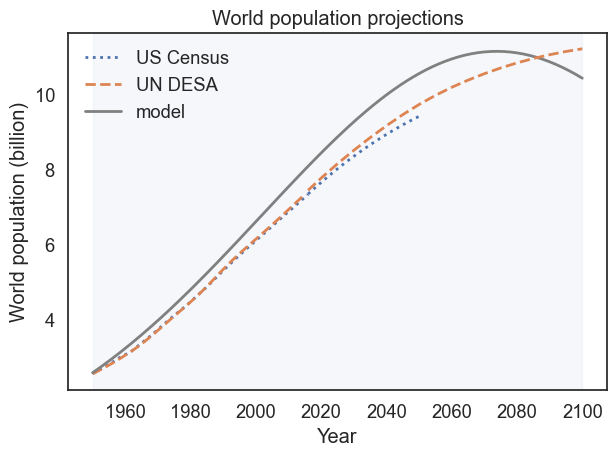

In [14]:
#6.
#Run a simulation from 1960 to 2100 with your update function, and plot the results.

results = run_simulation(system, update_alpha_func)

plt.axvspan(1950, 2100, color='C0', alpha=0.05)
plot_results(census, un, results, 'World population projections')
plot_projections(table3)
savefig('figs/chap08-fig04.pdf')


My projections follow the US Census and UN data very closely up until ~2000. From 2000 until ~2060 my projections are the highest, after which they dip relatively significantly and the UN DESA projections climb / remain the highest thru 2100. The US Census line stops at ~2050 but if it were to have been continued, it appears that this projection would have also been higher than my model by the time we reached the year 2100.

## Chapter 9

In [31]:
# import everything from SymPy.
from sympy import *

### Analysis with SymPy

In [32]:
# Run line-by-line to verify output

t = symbols('t')
expr = t + 1
type(expr)
expr.subs(t, 2)

f = Function('f')
type(f)
f(t)
dfdt = diff(f(t), t)
type(dfdt)

alpha = symbols('alpha')
eq1 = Eq(dfdt, alpha*f(t))
solution_eq = dsolve(eq1)

C1, p_0 = symbols('C1 p_0')
particular = solution_eq.subs(C1, p_0)

Eq(f(t), p_0*exp(alpha*t))

### Solving the quadratic growth equation

We'll use the (r, K) parameterization, so we'll need two more symbols:

In [64]:
r, K = symbols('r K') #use (r, K) parametrization
eq2 = Eq(diff(f(t), t), r * f(t) * (1 - f(t)/K)) #write the differential equation
solution_eq = dsolve(eq2) #solve differential equation
general = solution_eq.rhs #extract the right hand side
at_0 = general.subs(t, 0) #evaluate at t=0

K*exp(C1*K)/(exp(C1*K) - 1)

To find the value of `C1` that makes f(0) = `p_0`, create the equation `at_0` = `p_0` and solve for `C1`. *We use `solve` rather than `dsolve` because it's just an algebraic identity.*

The result is a list of solutions, from which we select the 1st entry using the bracket operator, `[0]`, to select the first one:

In [47]:
solutions = solve(Eq(at_0, p_0), C1)
type(solutions), len(solutions) #list, 1

value_of_C1 = solutions[0]
particular = general.subs(C1, value_of_C1) #plug in C1 value

particular = simplify(particular) #simplify the expression
particular.subs(t, 0) #evaluate at t=0


p_0

### Exercises

**Exercise 1.** Solve the quadratic growth equation using the alternative parameterization

$\frac{df(t)}{dt} = \alpha f(t) + \beta f^2(t) $

**Solution:**

In [69]:
#define alternative parameters
alpha = symbols('alpha')
beta = symbols('beta')

#Define differential equation with p representative of population
eq3 = Eq(diff(f(t), t), alpha * f(t) + (beta * f(t)**2)) #write the differential equation

solution_eq = dsolve(eq3) #solve differential equation
general = solution_eq.rhs #extract the right hand side
at_0 = general.subs(t, 0) #evaluate at t=0

solutions = solve(Eq(at_0, p_0), C1)
value_of_C1 = solutions[0]
particular = general.subs(C1, value_of_C1) #plug in C1 value

particular = simplify(particular) #simplify the expression
particular.subs(t, 0) #evaluate at t=0


[log(beta*p_0/(alpha + beta*p_0))/alpha]

Although we may have started with alternative parameters $\alpha, \beta$ rather than r, K, the solutions is the same: `p_0`.

**Exercise 2.**  Use [WolframAlpha](https://www.wolframalpha.com/) to solve the quadratic growth model, using either or both forms of parameterization:

    df(t) / dt = alpha f(t) + beta f(t)^2

or

    df(t) / dt = r f(t) (1 - f(t)/K)

Find the general solution and also the particular solution where `f(0) = p_0`.

**Solution:**

I input "df(t) / dt = alpha * f(t) + beta * f(t)^2" and received:

**general solution**: "f(t) = - (alpha * exp^(alpha * C + alpha * t)) / (beta * exp^(alpha * C + alpha * t) - 1)

I then input "Solve f(t) = - (alpha * exp^(alpha * C + alpha * t)) / (beta * exp^(alpha * C + alpha * t) - 1) for C" and Wolfram Alpha was unable to interpret ...

I tried a number of different input to no avail and came to the conclusion that leaning on programming languages (ie. Python) or platforms (ie. Wolfram Alpha) can be incredibly powerful. They save on mental capacity and eliminate the incidence of human error. *With this said, the user must be familiar with the language / platform and know how to input what it is that they're looking for and that's a skill in-and-of itself.*